This data set contains a sample of over 3 million grocery orders from more than 200,000 Instacart anonymized users. For each user, 4 to 100 of their orders are given, with the basket of products purchased in each order

The goal of this analysis will be to predict when a user will next place and order and which products will be in that order. 



Data Dictionary: 

orders (3.4m rows, 206k users):

order_id: order identifier
user_id: customer identifier
eval_set: which evaluation set this order belongs in 

"prior": orders prior to that users most recent order (~3.2m orders)
"train": training data supplied by InstaCart to for model training purposes (~131k orders)
"test": test data reserved for machine learning competitions (~75k orders)

order_number: the order sequence number for this user (1 = first, n = nth)
order_dow: the day of the week the order was placed on
order_hour_of_day: the hour of the day the order was placed on
days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

product_id: product identifier
product_name: name of the product
aisle_id: foreign key
department_id: foreign key
aisles (134 rows):

aisle_id: aisle identifier
aisle: the name of the aisle
deptartments (21 rows):

department_id: department identifier
department: the name of the department
order_products__SET (30m+ rows):

order_id: foreign key
product_id: foreign key
add_to_cart_order: order in which each product was added to cart
reordered: 1 if this product has been ordered by this user in the past, 0 otherwise
where SET is one of the four following evaluation sets (eval_set in orders):



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")
order_prior = pd.read_csv("data/order_products__prior.csv")
order_train = pd.read_csv("data/order_products__train.csv")
order = pd.read_csv("data/orders.csv")
products = pd.read_csv("data/products.csv")



In [62]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [63]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [64]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [13]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
order_prior.shape

(32434489, 4)

In [15]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [16]:
order_train.shape

(1384617, 4)

In [17]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [88]:
order.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [18]:
order.shape

(3421083, 7)

In [19]:
order.eval_set.value_counts()



prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [20]:
order.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [21]:
order.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

The data contains each initial order of a customer which is why the days_since_prior_order is NaN for those orders. 

In [22]:
order_clean = order.dropna(axis = 0)

In [23]:
order_clean.sort_values(by='days_since_prior_order',ascending=1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1282387,2225502,77127,prior,3,0,13,0.0
1129463,1779386,67912,prior,35,1,14,0.0
1129466,626316,67912,prior,38,2,16,0.0
1608619,3216292,96576,prior,3,2,20,0.0
1041248,2633645,62680,train,17,5,19,0.0
84951,1792181,5198,prior,8,6,22,0.0
1129470,435701,67912,prior,42,1,9,0.0
2235082,3369642,134620,prior,22,2,19,0.0
460665,2338055,27741,prior,5,2,10,0.0
1804618,584795,108391,prior,2,1,13,0.0


In [24]:
order.groupby('user_id').user_id.value_counts().max()

100

In [25]:
order.groupby('user_id').user_id.value_counts().min()

4

The max number of times the same user has ordered through InstaCart is 100 and the min is 4. 

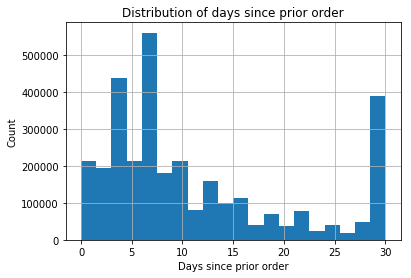

In [65]:
order_clean.hist(column="days_since_prior_order",bins=20);
plt.ylabel('Count');
plt.xlabel('Days since prior order');
plt.title("Distribution of days since prior order");



It looks like there is a spike in reorders around the 3rd, 7th and 30th day. 

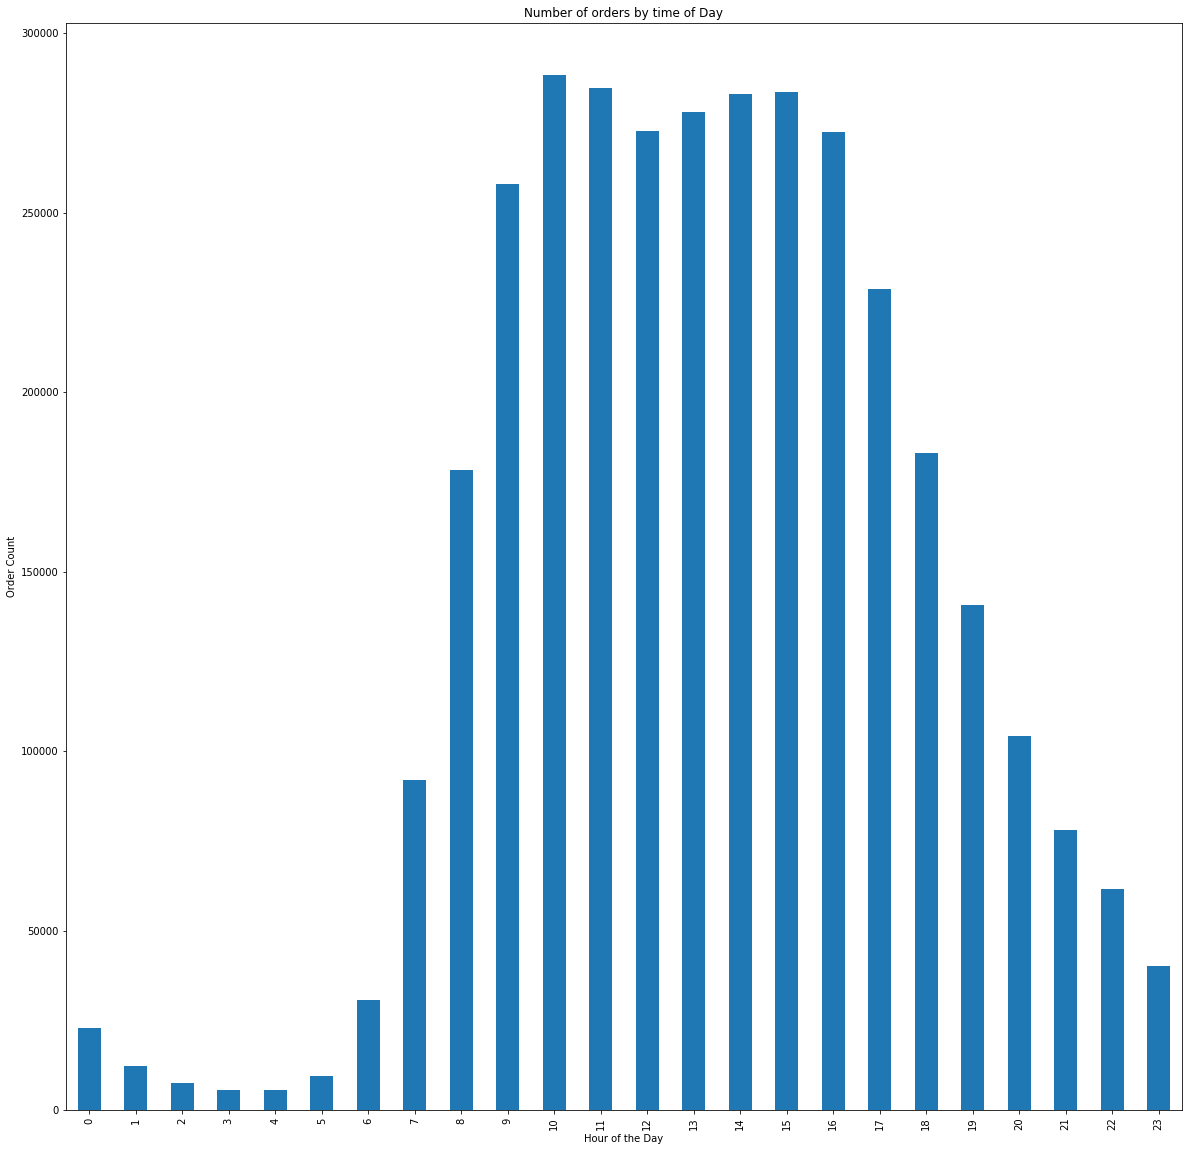

In [20]:
order.order_hour_of_day.value_counts().sort_index().plot(kind='bar', figsize=(20,20));    
plt.xlabel('Hour of the Day');
plt.ylabel('Order Count');
plt.title('Number of orders by time of Day');

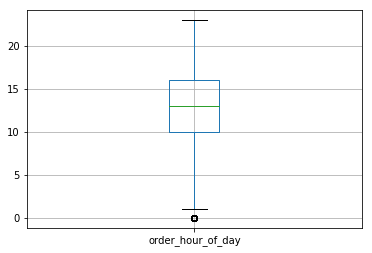

In [10]:
order.boxplot(column="order_hour_of_day");

Most orders tend to be placed in the afternoon.  

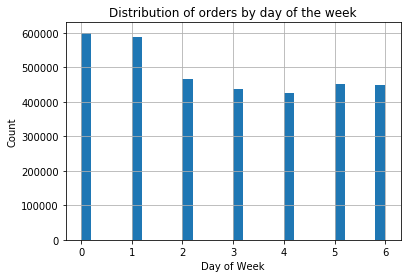

In [41]:
order.hist(column="order_dow",bins=30);
plt.ylabel('Count');
plt.xlabel('Day of Week');
plt.title('Distribution of orders by day of the week');

In [66]:
order.order_dow.value_counts()

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64

Saturday and Sunday appears to be when the number of orders placed are highest and Wednesday when they are lowest.

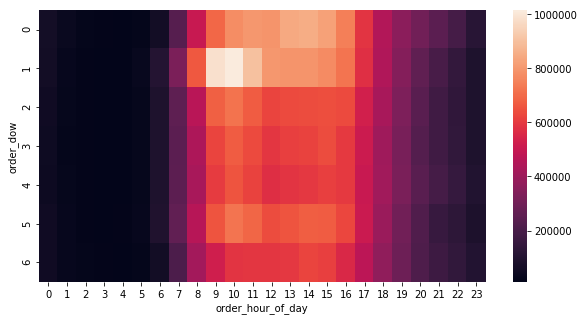

In [92]:

grouping = order.groupby(["order_dow", "order_hour_of_day"])["order_number"].sum().reset_index()
grouping = grouping.pivot('order_dow', 'order_hour_of_day', 'order_number')
plt.figure(figsize=(10,5))
sns.heatmap(grouping)


It appears that Saturday and Sunday mornings are the most popular times to place an order.

In [93]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [94]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [102]:
order_prior = pd.merge(order_prior, products, on='product_id', how='inner')
order_prior.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [112]:
top_products = order_prior.product_name.value_counts().head(20)


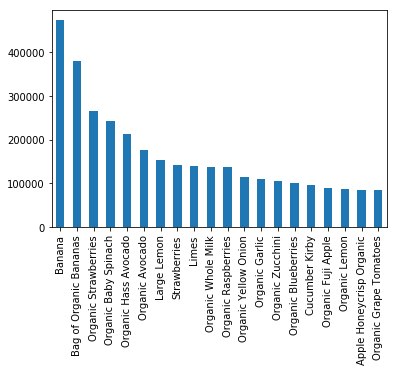

In [113]:
top_products.plot.bar()